In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from tqdm import tqdm
import json
import fasttext

In [2]:
with open(r"data/ATE_Train.json", 'r') as f:
    train_data = json.load(f)

with open(r'data/ATE_Val.json', 'r') as f:
    val_data = json.load(f)
    
with open(r'data/ATE_Test.json', 'r') as f:
    test_data = json.load(f)

In [3]:
model = fasttext.load_model("cc.en.300.bin")

In [4]:
word_embedding = model.get_word_vector('hello')
print(word_embedding)

[ 1.57576188e-01  4.37820926e-02 -4.51271934e-03  6.65931404e-02
  7.70346820e-02  4.85855248e-03  8.19822028e-03  6.52402919e-03
  9.25899856e-03  3.53899002e-02 -2.31395271e-02 -4.91807126e-02
 -8.32642540e-02  1.56014524e-02  2.54856616e-01  3.45423706e-02
 -1.07451361e-02 -7.80188590e-02 -7.08099529e-02  7.62385577e-02
 -6.09613657e-02  4.48625796e-02 -7.29744136e-02  1.30583309e-02
  3.14881057e-02 -3.10055036e-02  1.66004002e-02  1.74405202e-02
 -7.35838860e-02  1.18252613e-01 -1.21330231e-01 -4.09253240e-02
  2.93969568e-02  4.84445989e-02 -1.33816330e-02 -1.74765270e-02
  7.51308873e-02  9.97046307e-02 -4.00476977e-02  4.05735290e-03
 -7.21896589e-02 -4.43356819e-02 -1.22628408e-03  7.56693557e-02
  3.98401320e-02  3.22643593e-02  1.95914153e-02  4.68016043e-02
 -1.46228177e-02  1.12967767e-01  3.15065160e-02 -1.02312110e-01
  1.58124104e-01 -2.76147053e-02 -3.39851156e-02 -1.77006852e-02
 -5.73529862e-04  1.10789239e-01 -1.64533369e-02 -3.14955460e-03
 -4.22914140e-02  1.11429

In [5]:
def convert_data_to_tensors(data, model):
    texts = [data[key]['text'] for key in data]

    # Convert texts to word embeddings
    embeddings = []
    for text in texts:
        embedding = []
        for word in text.split():
                embedding.append(model.get_word_vector(word))
        embeddings.append(embedding)

    # Pad sequences to have the same length
    max_len = 83 # maximum length of word in 1 text 
    padded_embeddings = []
    for embedding in embeddings:
        padded_embedding = embedding + [[0] * len(model.get_word_vector("Hello"))] * (max_len - len(embedding))
        padded_embeddings.append(padded_embedding)

    input_ids = torch.tensor(padded_embeddings)

    return input_ids

In [6]:

x_train = convert_data_to_tensors(train_data, model)
x_val = convert_data_to_tensors(val_data, model)
x_test = convert_data_to_tensors(test_data, model)

/tmp/ipykernel_30803/1681424001.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  input_ids = torch.tensor(padded_embeddings)


In [7]:
x_train.size()

torch.Size([906, 83, 300])

In [8]:
def convert_labels_to_fixed_length(labels, max_length):
    new_list=[]
    label_to_index = {'B': 0, 'I': 1, 'O': 2,'<pad>':3}
    num_labels = len(label_to_index)
    fixed_length_labels = np.zeros((len(labels), max_length))
    for i, example_labels in enumerate(labels):
        for j, label in enumerate(example_labels[:max_length]):
            fixed_length_labels[i, j] = label_to_index[label]
        for k in range(len(example_labels[:max_length]),max_length):
            fixed_length_labels[i, k] = 3
        new_list.append(len(example_labels[:max_length]))
    return fixed_length_labels,new_list

max_length = 83
train_labels = [train_data[key]['labels'] for key in train_data]
train_lab,length_train = convert_labels_to_fixed_length(train_labels, max_length)
y_train = torch.tensor(train_lab)


val_labels = [val_data[key]['labels'] for key in val_data]
val_lab,length_val = convert_labels_to_fixed_length(val_labels, max_length)
y_val = torch.tensor(val_lab)

test_labels = [test_data[key]['labels'] for key in test_data]
test_lab,length_test = convert_labels_to_fixed_length(test_labels, max_length)
y_test = torch.tensor(test_lab)

In [9]:
y_train.size()

torch.Size([906, 83])

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
length_train_tensor = torch.tensor(length_train)
length_val_tensor = torch.tensor(length_val)

# Define the RNN model
class RNNTagger(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNTagger, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.rnn.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

# Define hyperparameters
input_size = 300  # Assuming word2vec embeddings size
hidden_size = 128
output_size = 4
learning_rate = 0.001
num_epochs = 150
batch_size = 128

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor,length_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Initialize model, loss, and optimizer
model = RNNTagger(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_f1_scores = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    total_f1=0
    for batch_X, batch_y,l in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        outputs_r = [row[:index] for row, index in zip(outputs, l)]
        outputs_r_flat = torch.cat(outputs_r)
        y_pred_train = torch.argmax(outputs, dim=2)
        y_pred_padd_r = [row[:index] for row, index in zip(y_pred_train, l)] 
        y_train_flat = torch.cat(y_pred_padd_r)
        batch_y_r =  [row[:index] for row, index in zip(batch_y, l)]
        y_pred_flat = torch.cat(batch_y_r)
        loss = criterion(outputs_r_flat,y_pred_flat )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        train_f1 = f1_score(y_train_flat, y_pred_flat, average='macro')
        total_f1 += train_f1
    train_f1_scores.append(total_f1/ len(train_loader))
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        # Calculate F1 score
        y_pred = torch.argmax(val_outputs, dim=2)
        y_pred_val_padd_r = [row[:index] for row, index in zip(y_pred, length_val_tensor)] 
        y_pred_val_flat = torch.cat(y_pred_val_padd_r)
        y_val_tensor_r =  [row[:index] for row, index in zip(y_val_tensor, length_val_tensor)]
        y_val_tensor_r_f = torch.cat(y_val_tensor_r)
        
        val_outputs_r = [row[:index] for row, index in zip(val_outputs, length_val_tensor)]
        val_outputs_r_f = torch.cat(val_outputs_r)
        
        val_loss = criterion(val_outputs_r_f,y_val_tensor_r_f)
        val_losses.append(val_loss.item())

        
        val_f1 = f1_score(y_val_tensor_r_f, y_pred_val_flat, average='macro')
        val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val F1: {val_f1}, Train F1: {train_f1_scores[-1]}")
    

/tmp/ipykernel_30803/2469601546.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train, dtype=torch.float32)
/tmp/ipykernel_30803/2469601546.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_30803/2469601546.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val, dtype=torch.float32)
/tmp/ipykernel_30803/2469601546.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

Epoch 1/150, Train Loss: 0.9406334757804871, Val Loss: 0.4491594135761261, Val F1: 0.31536422168918066, Train F1: 0.29950037150316555


  1%|█▉                                                                                                                                                | 2/150 [00:00<00:59,  2.47it/s]

Epoch 2/150, Train Loss: 0.4734298475086689, Val Loss: 0.438606321811676, Val F1: 0.31532441302701336, Train F1: 0.314051947646676


  2%|██▉                                                                                                                                               | 3/150 [00:01<00:54,  2.72it/s]

Epoch 3/150, Train Loss: 0.4362053796648979, Val Loss: 0.39500948786735535, Val F1: 0.31532441302701336, Train F1: 0.31448561757348176


  3%|███▉                                                                                                                                              | 4/150 [00:01<00:51,  2.85it/s]

Epoch 4/150, Train Loss: 0.3999006412923336, Val Loss: 0.3706001043319702, Val F1: 0.31532441302701336, Train F1: 0.31608858411172447


  3%|████▊                                                                                                                                             | 5/150 [00:01<00:49,  2.93it/s]

Epoch 5/150, Train Loss: 0.38389135897159576, Val Loss: 0.3534471094608307, Val F1: 0.3221328323861033, Train F1: 0.3202128198116492


  4%|█████▊                                                                                                                                            | 6/150 [00:02<00:48,  3.00it/s]

Epoch 6/150, Train Loss: 0.3600645959377289, Val Loss: 0.33262768387794495, Val F1: 0.3351382940863139, Train F1: 0.3257777881787476


  5%|██████▊                                                                                                                                           | 7/150 [00:02<00:46,  3.05it/s]

Epoch 7/150, Train Loss: 0.361300703138113, Val Loss: 0.30879873037338257, Val F1: 0.3476598197590226, Train F1: 0.33330888295429906


  5%|███████▊                                                                                                                                          | 8/150 [00:02<00:46,  3.04it/s]

Epoch 8/150, Train Loss: 0.3110633082687855, Val Loss: 0.2875811755657196, Val F1: 0.3819457634203758, Train F1: 0.3607372987483177


  6%|████████▊                                                                                                                                         | 9/150 [00:03<00:47,  2.99it/s]

Epoch 9/150, Train Loss: 0.2920553907752037, Val Loss: 0.2703576982021332, Val F1: 0.455142901466274, Train F1: 0.37471274581418673


  7%|█████████▋                                                                                                                                       | 10/150 [00:03<00:48,  2.89it/s]

Epoch 10/150, Train Loss: 0.2836921960115433, Val Loss: 0.255008727312088, Val F1: 0.49030396637934825, Train F1: 0.44242207377720283


  7%|██████████▋                                                                                                                                      | 11/150 [00:03<00:47,  2.94it/s]

Epoch 11/150, Train Loss: 0.2628501318395138, Val Loss: 0.24347653985023499, Val F1: 0.560864677611656, Train F1: 0.4609349301046113


  8%|███████████▌                                                                                                                                     | 12/150 [00:04<00:46,  2.96it/s]

Epoch 12/150, Train Loss: 0.25869386084377766, Val Loss: 0.2320307493209839, Val F1: 0.575533785129433, Train F1: 0.5363534858061757


  9%|████████████▌                                                                                                                                    | 13/150 [00:04<00:47,  2.86it/s]

Epoch 13/150, Train Loss: 0.23910739086568356, Val Loss: 0.22249047458171844, Val F1: 0.575643462460364, Train F1: 0.5466143150691907


  9%|█████████████▌                                                                                                                                   | 14/150 [00:04<00:49,  2.76it/s]

Epoch 14/150, Train Loss: 0.24429168552160263, Val Loss: 0.21487432718276978, Val F1: 0.6039533302291028, Train F1: 0.5664852640534425


 10%|██████████████▌                                                                                                                                  | 15/150 [00:05<00:50,  2.70it/s]

Epoch 15/150, Train Loss: 0.22783668339252472, Val Loss: 0.20780247449874878, Val F1: 0.6235433798380473, Train F1: 0.5907391027667752


 11%|███████████████▍                                                                                                                                 | 16/150 [00:05<00:48,  2.74it/s]

Epoch 16/150, Train Loss: 0.23177960515022278, Val Loss: 0.20164649188518524, Val F1: 0.6569539609685581, Train F1: 0.6081935493589858


 11%|████████████████▍                                                                                                                                | 17/150 [00:05<00:46,  2.85it/s]

Epoch 17/150, Train Loss: 0.21571600064635277, Val Loss: 0.20198194682598114, Val F1: 0.5738113103554933, Train F1: 0.6601914151281933


 12%|█████████████████▍                                                                                                                               | 18/150 [00:06<00:45,  2.93it/s]

Epoch 18/150, Train Loss: 0.2106918152421713, Val Loss: 0.1913967877626419, Val F1: 0.6424662098429647, Train F1: 0.6461248344792835


 13%|██████████████████▎                                                                                                                              | 19/150 [00:06<00:43,  3.00it/s]

Epoch 19/150, Train Loss: 0.19674726948142052, Val Loss: 0.1881573349237442, Val F1: 0.6533434173235939, Train F1: 0.6758079444303011


 13%|███████████████████▎                                                                                                                             | 20/150 [00:06<00:42,  3.05it/s]

Epoch 20/150, Train Loss: 0.19604137167334557, Val Loss: 0.18773506581783295, Val F1: 0.7296434972476993, Train F1: 0.6529592223120381


 14%|████████████████████▎                                                                                                                            | 21/150 [00:07<00:42,  3.06it/s]

Epoch 21/150, Train Loss: 0.1881034728139639, Val Loss: 0.18262198567390442, Val F1: 0.709659476706045, Train F1: 0.698975186489877


 15%|█████████████████████▎                                                                                                                           | 22/150 [00:07<00:41,  3.09it/s]

Epoch 22/150, Train Loss: 0.18160373903810978, Val Loss: 0.1817367523908615, Val F1: 0.6592888817642044, Train F1: 0.7018317771997009


 15%|██████████████████████▏                                                                                                                          | 23/150 [00:07<00:40,  3.11it/s]

Epoch 23/150, Train Loss: 0.19189746491611004, Val Loss: 0.17611347138881683, Val F1: 0.6939258191431258, Train F1: 0.7150110092950047


 16%|███████████████████████▏                                                                                                                         | 24/150 [00:08<00:40,  3.14it/s]

Epoch 24/150, Train Loss: 0.18178507313132286, Val Loss: 0.17497391998767853, Val F1: 0.7190700610301387, Train F1: 0.7263583428713566


 17%|████████████████████████▏                                                                                                                        | 25/150 [00:08<00:39,  3.16it/s]

Epoch 25/150, Train Loss: 0.18105380237102509, Val Loss: 0.18042416870594025, Val F1: 0.7475669824363389, Train F1: 0.7198548708533866


 17%|█████████████████████████▏                                                                                                                       | 26/150 [00:08<00:39,  3.14it/s]

Epoch 26/150, Train Loss: 0.17241626046597958, Val Loss: 0.17311443388462067, Val F1: 0.7419098894204424, Train F1: 0.7473740643739727


 18%|██████████████████████████                                                                                                                       | 27/150 [00:09<00:39,  3.14it/s]

Epoch 27/150, Train Loss: 0.16526670660823584, Val Loss: 0.17113231122493744, Val F1: 0.7038598548225363, Train F1: 0.7651990920483936


 19%|███████████████████████████                                                                                                                      | 28/150 [00:09<00:38,  3.14it/s]

Epoch 28/150, Train Loss: 0.17796888202428818, Val Loss: 0.16979056596755981, Val F1: 0.7236102945619778, Train F1: 0.740236441441741


 19%|████████████████████████████                                                                                                                     | 29/150 [00:09<00:38,  3.15it/s]

Epoch 29/150, Train Loss: 0.1712159812450409, Val Loss: 0.16980813443660736, Val F1: 0.748509932604958, Train F1: 0.7544591505046755


 20%|█████████████████████████████                                                                                                                    | 30/150 [00:10<00:38,  3.14it/s]

Epoch 30/150, Train Loss: 0.15990667790174484, Val Loss: 0.16856154799461365, Val F1: 0.7307370179462263, Train F1: 0.7697103611726109


 21%|█████████████████████████████▉                                                                                                                   | 31/150 [00:10<00:38,  3.12it/s]

Epoch 31/150, Train Loss: 0.17629475519061089, Val Loss: 0.16662515699863434, Val F1: 0.7255517323894947, Train F1: 0.7468578609824738


 21%|██████████████████████████████▉                                                                                                                  | 32/150 [00:10<00:38,  3.03it/s]

Epoch 32/150, Train Loss: 0.16158449463546276, Val Loss: 0.1657208502292633, Val F1: 0.7349991296547614, Train F1: 0.7617648586564285


 22%|███████████████████████████████▉                                                                                                                 | 33/150 [00:11<00:39,  2.97it/s]

Epoch 33/150, Train Loss: 0.1553134061396122, Val Loss: 0.16595396399497986, Val F1: 0.7183131068125927, Train F1: 0.7785044676024288


 23%|████████████████████████████████▊                                                                                                                | 34/150 [00:11<00:40,  2.87it/s]

Epoch 34/150, Train Loss: 0.1602814644575119, Val Loss: 0.16578885912895203, Val F1: 0.7216069330274384, Train F1: 0.7653659570487561


 23%|█████████████████████████████████▊                                                                                                               | 35/150 [00:11<00:38,  2.96it/s]

Epoch 35/150, Train Loss: 0.15928432159125805, Val Loss: 0.16493763029575348, Val F1: 0.7236584858777441, Train F1: 0.7727683696641997


 24%|██████████████████████████████████▊                                                                                                              | 36/150 [00:12<00:39,  2.89it/s]

Epoch 36/150, Train Loss: 0.1498387772589922, Val Loss: 0.17230433225631714, Val F1: 0.6800730847156172, Train F1: 0.7988929152809864


 25%|███████████████████████████████████▊                                                                                                             | 37/150 [00:12<00:39,  2.88it/s]

Epoch 37/150, Train Loss: 0.1648813784122467, Val Loss: 0.16512362658977509, Val F1: 0.726631723448786, Train F1: 0.7707166362566781


 25%|████████████████████████████████████▋                                                                                                            | 38/150 [00:12<00:38,  2.88it/s]

Epoch 38/150, Train Loss: 0.1529260016977787, Val Loss: 0.16364164650440216, Val F1: 0.7298422327318893, Train F1: 0.7999487033178028


 26%|█████████████████████████████████████▋                                                                                                           | 39/150 [00:13<00:38,  2.86it/s]

Epoch 39/150, Train Loss: 0.14563180692493916, Val Loss: 0.16282394528388977, Val F1: 0.746999629478359, Train F1: 0.8051340126753835


 27%|██████████████████████████████████████▋                                                                                                          | 40/150 [00:13<00:38,  2.89it/s]

Epoch 40/150, Train Loss: 0.13707168865948915, Val Loss: 0.1654163897037506, Val F1: 0.7149420492269801, Train F1: 0.821349946663462


 27%|███████████████████████████████████████▋                                                                                                         | 41/150 [00:13<00:36,  2.97it/s]

Epoch 41/150, Train Loss: 0.13769740890711546, Val Loss: 0.1624916046857834, Val F1: 0.7337993746450371, Train F1: 0.7834281558053833


 28%|████████████████████████████████████████▌                                                                                                        | 42/150 [00:14<00:35,  3.02it/s]

Epoch 42/150, Train Loss: 0.13741908874362707, Val Loss: 0.16545021533966064, Val F1: 0.7579883987649976, Train F1: 0.8133753993093618


 29%|█████████████████████████████████████████▌                                                                                                       | 43/150 [00:14<00:34,  3.07it/s]

Epoch 43/150, Train Loss: 0.14739406574517488, Val Loss: 0.17125143110752106, Val F1: 0.7549241834184263, Train F1: 0.8030174922353757


 29%|██████████████████████████████████████████▌                                                                                                      | 44/150 [00:14<00:34,  3.10it/s]

Epoch 44/150, Train Loss: 0.13838378805667162, Val Loss: 0.16220857203006744, Val F1: 0.7465889975583785, Train F1: 0.7987556799635737


 30%|███████████████████████████████████████████▌                                                                                                     | 45/150 [00:15<00:33,  3.14it/s]

Epoch 45/150, Train Loss: 0.1403509806841612, Val Loss: 0.16479142010211945, Val F1: 0.7193624550958063, Train F1: 0.8052605808439048


 31%|████████████████████████████████████████████▍                                                                                                    | 46/150 [00:15<00:32,  3.16it/s]

Epoch 46/150, Train Loss: 0.13339104130864143, Val Loss: 0.1682799905538559, Val F1: 0.7065445394658822, Train F1: 0.8206382725155842


 31%|█████████████████████████████████████████████▍                                                                                                   | 47/150 [00:15<00:32,  3.17it/s]

Epoch 47/150, Train Loss: 0.13633101806044579, Val Loss: 0.16950419545173645, Val F1: 0.7220390955895607, Train F1: 0.8069466810124322


 32%|██████████████████████████████████████████████▍                                                                                                  | 48/150 [00:16<00:32,  3.18it/s]

Epoch 48/150, Train Loss: 0.145797623321414, Val Loss: 0.16682718694210052, Val F1: 0.7462388062270228, Train F1: 0.8132838580446827


 33%|███████████████████████████████████████████████▎                                                                                                 | 49/150 [00:16<00:31,  3.20it/s]

Epoch 49/150, Train Loss: 0.13790876138955355, Val Loss: 0.16532227396965027, Val F1: 0.7539476246473752, Train F1: 0.8205096610693016


 33%|████████████████████████████████████████████████▎                                                                                                | 50/150 [00:16<00:31,  3.20it/s]

Epoch 50/150, Train Loss: 0.12962839007377625, Val Loss: 0.1693987399339676, Val F1: 0.7073126525517553, Train F1: 0.7824716811765564


 34%|█████████████████████████████████████████████████▎                                                                                               | 51/150 [00:17<00:30,  3.20it/s]

Epoch 51/150, Train Loss: 0.12279606983065605, Val Loss: 0.1719982922077179, Val F1: 0.7081538488874656, Train F1: 0.8366945216519784


 35%|██████████████████████████████████████████████████▎                                                                                              | 52/150 [00:17<00:30,  3.21it/s]

Epoch 52/150, Train Loss: 0.1361870039254427, Val Loss: 0.16406887769699097, Val F1: 0.7440625163904576, Train F1: 0.8275416862773322


 35%|███████████████████████████████████████████████████▏                                                                                             | 53/150 [00:17<00:30,  3.21it/s]

Epoch 53/150, Train Loss: 0.12113470118492842, Val Loss: 0.1661795675754547, Val F1: 0.7205521331123971, Train F1: 0.8360307675786469


 36%|████████████████████████████████████████████████████▏                                                                                            | 54/150 [00:17<00:29,  3.20it/s]

Epoch 54/150, Train Loss: 0.11547915637493134, Val Loss: 0.17316894233226776, Val F1: 0.7235986844808017, Train F1: 0.8115655394227544


 37%|█████████████████████████████████████████████████████▏                                                                                           | 55/150 [00:18<00:29,  3.19it/s]

Epoch 55/150, Train Loss: 0.12358125392347574, Val Loss: 0.16811732947826385, Val F1: 0.7199804436904241, Train F1: 0.8290915932872787


 37%|██████████████████████████████████████████████████████▏                                                                                          | 56/150 [00:18<00:29,  3.19it/s]

Epoch 56/150, Train Loss: 0.12195391673594713, Val Loss: 0.17219993472099304, Val F1: 0.7368870459143069, Train F1: 0.8462255745525455


 38%|███████████████████████████████████████████████████████                                                                                          | 57/150 [00:18<00:30,  3.01it/s]

Epoch 57/150, Train Loss: 0.11106964945793152, Val Loss: 0.17540428042411804, Val F1: 0.7009623849932408, Train F1: 0.8625823481987203


 39%|████████████████████████████████████████████████████████                                                                                         | 58/150 [00:19<00:30,  3.03it/s]

Epoch 58/150, Train Loss: 0.11025927122682333, Val Loss: 0.17668253183364868, Val F1: 0.7316835218593543, Train F1: 0.8514278925830083


 39%|█████████████████████████████████████████████████████████                                                                                        | 59/150 [00:19<00:29,  3.06it/s]

Epoch 59/150, Train Loss: 0.1159919984638691, Val Loss: 0.1716107875108719, Val F1: 0.7390353844853488, Train F1: 0.8527856419526814


 40%|██████████████████████████████████████████████████████████                                                                                       | 60/150 [00:20<00:31,  2.84it/s]

Epoch 60/150, Train Loss: 0.10427688993513584, Val Loss: 0.1714644581079483, Val F1: 0.7288376384757093, Train F1: 0.8672232801422225


 41%|██████████████████████████████████████████████████████████▉                                                                                      | 61/150 [00:20<00:31,  2.79it/s]

Epoch 61/150, Train Loss: 0.1042492100968957, Val Loss: 0.1789126694202423, Val F1: 0.7270763870226947, Train F1: 0.8448429916905071


 41%|███████████████████████████████████████████████████████████▉                                                                                     | 62/150 [00:20<00:30,  2.84it/s]

Epoch 62/150, Train Loss: 0.11133051570504904, Val Loss: 0.17907461524009705, Val F1: 0.7477792915519966, Train F1: 0.8517603880124515


 42%|████████████████████████████████████████████████████████████▉                                                                                    | 63/150 [00:21<00:30,  2.90it/s]

Epoch 63/150, Train Loss: 0.09975549159571528, Val Loss: 0.18367239832878113, Val F1: 0.7397147711747163, Train F1: 0.8773359542050149


 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 64/150 [00:21<00:29,  2.93it/s]

Epoch 64/150, Train Loss: 0.09682562993839383, Val Loss: 0.18454188108444214, Val F1: 0.7339863984128923, Train F1: 0.8727947863966832


 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 65/150 [00:21<00:28,  2.93it/s]

Epoch 65/150, Train Loss: 0.10377980954945087, Val Loss: 0.18268021941184998, Val F1: 0.732701961196204, Train F1: 0.8638594460464895


 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 66/150 [00:22<00:28,  2.95it/s]

Epoch 66/150, Train Loss: 0.0957962516695261, Val Loss: 0.18020294606685638, Val F1: 0.7236951033155137, Train F1: 0.8892282077563285


 45%|████████████████████████████████████████████████████████████████▊                                                                                | 67/150 [00:22<00:27,  3.01it/s]

Epoch 67/150, Train Loss: 0.09407612588256598, Val Loss: 0.19240102171897888, Val F1: 0.7275388725994483, Train F1: 0.8886045986611111


 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 68/150 [00:22<00:27,  3.01it/s]

Epoch 68/150, Train Loss: 0.09416207950562239, Val Loss: 0.1841326653957367, Val F1: 0.7213264699342842, Train F1: 0.8787921747718341


 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 69/150 [00:23<00:26,  3.03it/s]

Epoch 69/150, Train Loss: 0.09643735736608505, Val Loss: 0.18299813568592072, Val F1: 0.7384101310482164, Train F1: 0.8777291026033077


 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 70/150 [00:23<00:26,  3.04it/s]

Epoch 70/150, Train Loss: 0.09336120169609785, Val Loss: 0.19232065975666046, Val F1: 0.7207218356875377, Train F1: 0.8901936561926728


 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 71/150 [00:23<00:26,  2.94it/s]

Epoch 71/150, Train Loss: 0.09394176304340363, Val Loss: 0.1988096535205841, Val F1: 0.7125342832457012, Train F1: 0.8834555115440327


 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 72/150 [00:24<00:26,  2.90it/s]

Epoch 72/150, Train Loss: 0.08579641534015536, Val Loss: 0.19195599853992462, Val F1: 0.7137531048582731, Train F1: 0.8980330304008176


 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 73/150 [00:24<00:26,  2.90it/s]

Epoch 73/150, Train Loss: 0.08734153397381306, Val Loss: 0.19796234369277954, Val F1: 0.7023674872154902, Train F1: 0.8862601062793241


 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 74/150 [00:24<00:26,  2.87it/s]

Epoch 74/150, Train Loss: 0.08991424553096294, Val Loss: 0.19678767025470734, Val F1: 0.7181832940076637, Train F1: 0.8874378443044489


 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 75/150 [00:25<00:26,  2.81it/s]

Epoch 75/150, Train Loss: 0.08731818851083517, Val Loss: 0.20233254134655, Val F1: 0.6927282904186111, Train F1: 0.8924326508596909


 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 76/150 [00:25<00:26,  2.84it/s]

Epoch 76/150, Train Loss: 0.08966458402574062, Val Loss: 0.208503857254982, Val F1: 0.7158312488593926, Train F1: 0.8971135571729467


 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 77/150 [00:25<00:25,  2.91it/s]

Epoch 77/150, Train Loss: 0.08471173653379083, Val Loss: 0.21543149650096893, Val F1: 0.6668747393082062, Train F1: 0.8996436286577151


 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 78/150 [00:26<00:24,  2.89it/s]

Epoch 78/150, Train Loss: 0.08892609272152185, Val Loss: 0.2176060974597931, Val F1: 0.6990065750388056, Train F1: 0.8758494713646148


 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 79/150 [00:26<00:24,  2.88it/s]

Epoch 79/150, Train Loss: 0.08472376316785812, Val Loss: 0.2100338190793991, Val F1: 0.6976951662563438, Train F1: 0.8984629339336311


 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 80/150 [00:26<00:23,  2.95it/s]

Epoch 80/150, Train Loss: 0.07893314491957426, Val Loss: 0.20150119066238403, Val F1: 0.7011498434820326, Train F1: 0.9000674786303261


 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                  | 81/150 [00:27<00:23,  2.93it/s]

Epoch 81/150, Train Loss: 0.08314788900315762, Val Loss: 0.21538102626800537, Val F1: 0.705664967693261, Train F1: 0.8975144741063465


 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                 | 82/150 [00:27<00:22,  2.99it/s]

Epoch 82/150, Train Loss: 0.07743526110425591, Val Loss: 0.20079198479652405, Val F1: 0.7021030299794438, Train F1: 0.9088530031251402


 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                | 83/150 [00:27<00:22,  3.03it/s]

Epoch 83/150, Train Loss: 0.08295912109315395, Val Loss: 0.20372074842453003, Val F1: 0.72002519170836, Train F1: 0.8980645508555096


 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                               | 84/150 [00:28<00:21,  3.04it/s]

Epoch 84/150, Train Loss: 0.07163568073883653, Val Loss: 0.21373549103736877, Val F1: 0.6979454082688061, Train F1: 0.9164303844522249


 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/150 [00:28<00:21,  3.07it/s]

Epoch 85/150, Train Loss: 0.07864740490913391, Val Loss: 0.22511422634124756, Val F1: 0.7136421207958126, Train F1: 0.9183498933539277


 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                             | 86/150 [00:28<00:20,  3.07it/s]

Epoch 86/150, Train Loss: 0.07988941110670567, Val Loss: 0.22414137423038483, Val F1: 0.6955416452142179, Train F1: 0.9048700903870717


 58%|████████████████████████████████████████████████████████████████████████████████████                                                             | 87/150 [00:29<00:20,  3.09it/s]

Epoch 87/150, Train Loss: 0.073924639262259, Val Loss: 0.21022911369800568, Val F1: 0.7093185700222379, Train F1: 0.9137489231917645


 59%|█████████████████████████████████████████████████████████████████████████████████████                                                            | 88/150 [00:29<00:20,  3.04it/s]

Epoch 88/150, Train Loss: 0.06572731770575047, Val Loss: 0.22521744668483734, Val F1: 0.7044679169844406, Train F1: 0.9303336053085586


 59%|██████████████████████████████████████████████████████████████████████████████████████                                                           | 89/150 [00:29<00:20,  3.04it/s]

Epoch 89/150, Train Loss: 0.0665716016665101, Val Loss: 0.21678411960601807, Val F1: 0.7079218560894857, Train F1: 0.918986814917403


 60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 90/150 [00:30<00:20,  2.97it/s]

Epoch 90/150, Train Loss: 0.06649366300553083, Val Loss: 0.21975649893283844, Val F1: 0.7121198231245672, Train F1: 0.9281287348186052


 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                         | 91/150 [00:30<00:20,  2.92it/s]

Epoch 91/150, Train Loss: 0.06828556954860687, Val Loss: 0.2236071527004242, Val F1: 0.7036586465095133, Train F1: 0.9266684444103754


 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 92/150 [00:30<00:20,  2.89it/s]

Epoch 92/150, Train Loss: 0.06477895984426141, Val Loss: 0.22483119368553162, Val F1: 0.696561108202232, Train F1: 0.9191355761774307


 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 93/150 [00:31<00:19,  2.92it/s]

Epoch 93/150, Train Loss: 0.06260243011638522, Val Loss: 0.2369401603937149, Val F1: 0.6885349852521724, Train F1: 0.9353227454153811


 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 94/150 [00:31<00:18,  2.97it/s]

Epoch 94/150, Train Loss: 0.05870304862037301, Val Loss: 0.22294144332408905, Val F1: 0.7184248658877307, Train F1: 0.9384390973043666


 63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 95/150 [00:31<00:18,  3.01it/s]

Epoch 95/150, Train Loss: 0.05521952174603939, Val Loss: 0.22930093109607697, Val F1: 0.7103751006143016, Train F1: 0.9441522440890107


 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 96/150 [00:32<00:17,  3.04it/s]

Epoch 96/150, Train Loss: 0.05471540242433548, Val Loss: 0.24065960943698883, Val F1: 0.6945520469245476, Train F1: 0.9501803489283012


 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 97/150 [00:32<00:17,  3.07it/s]

Epoch 97/150, Train Loss: 0.05366403004154563, Val Loss: 0.24281030893325806, Val F1: 0.6930180920327791, Train F1: 0.9506258616966028


 65%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 98/150 [00:32<00:17,  2.98it/s]

Epoch 98/150, Train Loss: 0.051973913330584764, Val Loss: 0.23687411844730377, Val F1: 0.6972100647626189, Train F1: 0.9483473688014088


 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 99/150 [00:33<00:16,  3.02it/s]

Epoch 99/150, Train Loss: 0.05663898400962353, Val Loss: 0.24224580824375153, Val F1: 0.7138191561132982, Train F1: 0.9483469600635913


 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 100/150 [00:33<00:17,  2.80it/s]

Epoch 100/150, Train Loss: 0.050010274862870574, Val Loss: 0.2421613186597824, Val F1: 0.7026250028566426, Train F1: 0.9532084151720197


 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 101/150 [00:33<00:17,  2.88it/s]

Epoch 101/150, Train Loss: 0.0481709698215127, Val Loss: 0.24900908768177032, Val F1: 0.6858878526390804, Train F1: 0.9483021218077702


 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 102/150 [00:34<00:16,  2.94it/s]

Epoch 102/150, Train Loss: 0.051356950774788857, Val Loss: 0.25115862488746643, Val F1: 0.7209935339101464, Train F1: 0.9563736018436653


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 103/150 [00:34<00:15,  2.96it/s]

Epoch 103/150, Train Loss: 0.048624251037836075, Val Loss: 0.25435999035835266, Val F1: 0.7007660310437761, Train F1: 0.9541736094500839


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 104/150 [00:34<00:15,  3.00it/s]

Epoch 104/150, Train Loss: 0.04573777713812888, Val Loss: 0.2655535340309143, Val F1: 0.677024176081875, Train F1: 0.9606912407428964


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 105/150 [00:35<00:14,  3.03it/s]

Epoch 105/150, Train Loss: 0.04536742437630892, Val Loss: 0.25521278381347656, Val F1: 0.688995935571278, Train F1: 0.959583059214732


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 106/150 [00:35<00:14,  3.00it/s]

Epoch 106/150, Train Loss: 0.04587689787149429, Val Loss: 0.26873835921287537, Val F1: 0.6927694423960548, Train F1: 0.9550798035318029


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 107/150 [00:35<00:14,  3.02it/s]

Epoch 107/150, Train Loss: 0.053679287899285555, Val Loss: 0.27118271589279175, Val F1: 0.689649455722735, Train F1: 0.9476974898039434


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 108/150 [00:36<00:13,  3.00it/s]

Epoch 108/150, Train Loss: 0.04481949401088059, Val Loss: 0.2580631375312805, Val F1: 0.7105093356860236, Train F1: 0.953414395578537


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 109/150 [00:36<00:13,  3.03it/s]

Epoch 109/150, Train Loss: 0.044151530135422945, Val Loss: 0.27182331681251526, Val F1: 0.6846012597124194, Train F1: 0.958114440213661


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 110/150 [00:36<00:13,  3.02it/s]

Epoch 110/150, Train Loss: 0.049325933679938316, Val Loss: 0.27601414918899536, Val F1: 0.6736099604755296, Train F1: 0.9581812123252663


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 111/150 [00:37<00:12,  3.03it/s]

Epoch 111/150, Train Loss: 0.0452996757812798, Val Loss: 0.2698208689689636, Val F1: 0.6987776096499099, Train F1: 0.9548583770725287


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 112/150 [00:37<00:12,  3.02it/s]

Epoch 112/150, Train Loss: 0.04198973858729005, Val Loss: 0.2773955166339874, Val F1: 0.6952493506888251, Train F1: 0.9625862905177878


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 113/150 [00:37<00:12,  3.03it/s]

Epoch 113/150, Train Loss: 0.03891863627359271, Val Loss: 0.28026336431503296, Val F1: 0.6819048062005209, Train F1: 0.9676257605133617


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 114/150 [00:38<00:12,  3.00it/s]

Epoch 114/150, Train Loss: 0.03985222824849188, Val Loss: 0.2695961594581604, Val F1: 0.6928026432778652, Train F1: 0.9633435674801824


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 115/150 [00:38<00:11,  3.03it/s]

Epoch 115/150, Train Loss: 0.0375555872451514, Val Loss: 0.27202698588371277, Val F1: 0.7037292438652178, Train F1: 0.969077052056993


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 116/150 [00:38<00:11,  3.00it/s]

Epoch 116/150, Train Loss: 0.037023883778601885, Val Loss: 0.28135815262794495, Val F1: 0.6859002880153261, Train F1: 0.9612849389802063


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 117/150 [00:39<00:10,  3.01it/s]

Epoch 117/150, Train Loss: 0.04140568105503917, Val Loss: 0.2913760840892792, Val F1: 0.6859031891240667, Train F1: 0.9642217874479662


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 118/150 [00:39<00:10,  3.00it/s]

Epoch 118/150, Train Loss: 0.03937501576729119, Val Loss: 0.29039308428764343, Val F1: 0.6939419155542709, Train F1: 0.9638696438731286


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 119/150 [00:39<00:10,  2.99it/s]

Epoch 119/150, Train Loss: 0.03783514117822051, Val Loss: 0.28081074357032776, Val F1: 0.6903301273237602, Train F1: 0.9669477642792735


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 120/150 [00:40<00:10,  2.97it/s]

Epoch 120/150, Train Loss: 0.035979269072413445, Val Loss: 0.2921721339225769, Val F1: 0.6681669533790586, Train F1: 0.9679483106049397


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 121/150 [00:40<00:09,  3.01it/s]

Epoch 121/150, Train Loss: 0.03473230171948671, Val Loss: 0.2796829044818878, Val F1: 0.695153370153664, Train F1: 0.9703633505250644


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 122/150 [00:40<00:09,  3.00it/s]

Epoch 122/150, Train Loss: 0.03494858951307833, Val Loss: 0.2985594868659973, Val F1: 0.6772263292974227, Train F1: 0.9703226403599247


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 123/150 [00:41<00:08,  3.04it/s]

Epoch 123/150, Train Loss: 0.05442346539348364, Val Loss: 0.302883505821228, Val F1: 0.6876082405599075, Train F1: 0.9421381810695239


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 124/150 [00:41<00:08,  3.05it/s]

Epoch 124/150, Train Loss: 0.06127737811766565, Val Loss: 0.2948072850704193, Val F1: 0.7017504929818555, Train F1: 0.9224457025734211


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 125/150 [00:41<00:08,  3.02it/s]

Epoch 125/150, Train Loss: 0.05161328101530671, Val Loss: 0.25586211681365967, Val F1: 0.7166087554566035, Train F1: 0.9441823884660787


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 126/150 [00:42<00:08,  2.97it/s]

Epoch 126/150, Train Loss: 0.04221027484163642, Val Loss: 0.26768267154693604, Val F1: 0.7040039348854883, Train F1: 0.9569738655615894


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 127/150 [00:42<00:07,  2.93it/s]

Epoch 127/150, Train Loss: 0.03919387306086719, Val Loss: 0.2616027891635895, Val F1: 0.7160894019906832, Train F1: 0.9633669859993808


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 128/150 [00:42<00:07,  2.89it/s]

Epoch 128/150, Train Loss: 0.036593523574993014, Val Loss: 0.26735901832580566, Val F1: 0.7194222155073812, Train F1: 0.9643369556615141


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 129/150 [00:43<00:07,  2.90it/s]

Epoch 129/150, Train Loss: 0.03611409547738731, Val Loss: 0.2926851212978363, Val F1: 0.6871055600351585, Train F1: 0.9717920406771824


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 130/150 [00:43<00:06,  2.91it/s]

Epoch 130/150, Train Loss: 0.03428197139874101, Val Loss: 0.2743108570575714, Val F1: 0.7040978359124147, Train F1: 0.9702473482281891


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 131/150 [00:43<00:06,  2.95it/s]

Epoch 131/150, Train Loss: 0.03407499939203262, Val Loss: 0.28246164321899414, Val F1: 0.7033888995864803, Train F1: 0.9711796955061238


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 132/150 [00:44<00:06,  2.97it/s]

Epoch 132/150, Train Loss: 0.030117010814137757, Val Loss: 0.2995584011077881, Val F1: 0.6953581969803647, Train F1: 0.9768381346231538


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 133/150 [00:44<00:05,  2.99it/s]

Epoch 133/150, Train Loss: 0.031118307495489717, Val Loss: 0.299079954624176, Val F1: 0.6892794112179733, Train F1: 0.9762564529259494


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 134/150 [00:44<00:05,  3.00it/s]

Epoch 134/150, Train Loss: 0.02962702140212059, Val Loss: 0.29552924633026123, Val F1: 0.6851223423978842, Train F1: 0.974243433879562


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 135/150 [00:45<00:04,  3.01it/s]

Epoch 135/150, Train Loss: 0.028120521339587867, Val Loss: 0.2982393801212311, Val F1: 0.6894594767455682, Train F1: 0.9780721050431974


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 136/150 [00:45<00:04,  3.03it/s]

Epoch 136/150, Train Loss: 0.03987781307660043, Val Loss: 0.3016270697116852, Val F1: 0.6908930449337266, Train F1: 0.9782235224204816


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 137/150 [00:45<00:04,  2.91it/s]

Epoch 137/150, Train Loss: 0.026588164502754807, Val Loss: 0.31113505363464355, Val F1: 0.6813180156915623, Train F1: 0.9835727935158981


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 138/150 [00:46<00:04,  2.95it/s]

Epoch 138/150, Train Loss: 0.025691002840176225, Val Loss: 0.3121128976345062, Val F1: 0.6827884818501176, Train F1: 0.980318648269772


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 139/150 [00:46<00:03,  2.95it/s]

Epoch 139/150, Train Loss: 0.029719174141064286, Val Loss: 0.3269513249397278, Val F1: 0.6830715027245463, Train F1: 0.9775299151347976


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 140/150 [00:46<00:03,  2.95it/s]

Epoch 140/150, Train Loss: 0.026962750824168324, Val Loss: 0.3063267767429352, Val F1: 0.6984067043574914, Train F1: 0.9767417331031233


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 141/150 [00:47<00:03,  2.99it/s]

Epoch 141/150, Train Loss: 0.028131847269833088, Val Loss: 0.31297871470451355, Val F1: 0.6920633179963116, Train F1: 0.9766240439599536


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 142/150 [00:47<00:02,  2.97it/s]

Epoch 142/150, Train Loss: 0.025097673293203115, Val Loss: 0.3270859718322754, Val F1: 0.6704628904556064, Train F1: 0.9808127283109461


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 143/150 [00:47<00:02,  2.99it/s]

Epoch 143/150, Train Loss: 0.0263022780418396, Val Loss: 0.3293529152870178, Val F1: 0.6811367760252347, Train F1: 0.9800210981429816


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 144/150 [00:48<00:01,  3.02it/s]

Epoch 144/150, Train Loss: 0.02328857348766178, Val Loss: 0.32560402154922485, Val F1: 0.6894568751319673, Train F1: 0.9838411119793453


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 145/150 [00:48<00:01,  3.01it/s]

Epoch 145/150, Train Loss: 0.023254601168446243, Val Loss: 0.3385562598705292, Val F1: 0.6637983820574117, Train F1: 0.9854584502891578


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 146/150 [00:48<00:01,  3.05it/s]

Epoch 146/150, Train Loss: 0.023897293023765087, Val Loss: 0.32900166511535645, Val F1: 0.6917965438882726, Train F1: 0.9845958800923148


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 147/150 [00:49<00:00,  3.06it/s]

Epoch 147/150, Train Loss: 0.026114443549886346, Val Loss: 0.33527228236198425, Val F1: 0.6670060524685469, Train F1: 0.9826275568516553


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 148/150 [00:49<00:00,  3.05it/s]

Epoch 148/150, Train Loss: 0.032387326238676906, Val Loss: 0.314899742603302, Val F1: 0.711456694558208, Train F1: 0.9646602186471387


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 149/150 [00:49<00:00,  3.06it/s]

Epoch 149/150, Train Loss: 0.03602650738321245, Val Loss: 0.33914536237716675, Val F1: 0.6802022556846267, Train F1: 0.9642813695849061


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:50<00:00,  2.99it/s]

Epoch 150/150, Train Loss: 0.02983205276541412, Val Loss: 0.3447127640247345, Val F1: 0.670477785630395, Train F1: 0.9728719855692967


In [12]:
# Save the model
torch.save(model.state_dict(), 't2_model1_fasttext.pth')

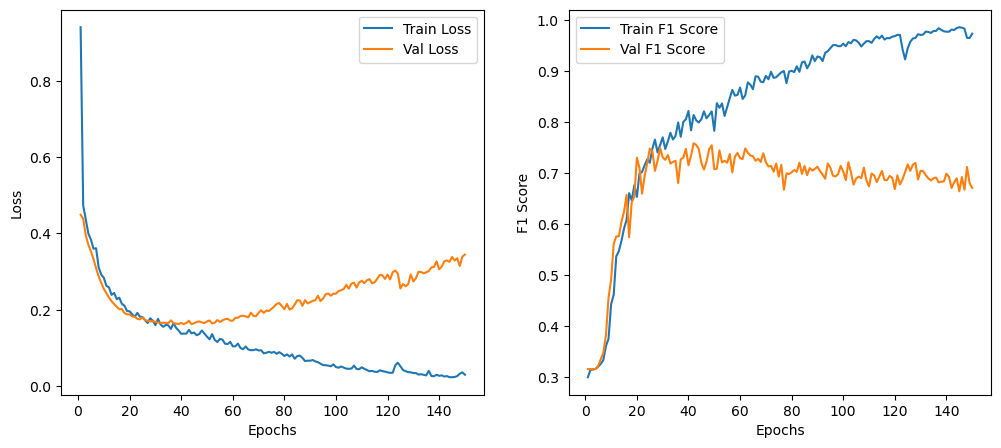

In [13]:
# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_f1_scores, label='Train F1 Score')
plt.plot(range(1, num_epochs + 1), val_f1_scores, label='Val F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.show()